# Finger signs

<a target="_blank" href="https://colab.research.google.com/github/LuisAngelMendozaVelasco/luisangelmendozavelasco.github.io/blob/master/_portfolio/Deep_Learning_Specialization/portfolio-2.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Run in Google Colab</a>

**Objective**: Build a convolutional neural network and train the [ResNet50V2](https://arxiv.org/pdf/1603.05027) architecture to classify a collection of 6 signs representing numbers from 0 to 5.

## Import libraries

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from keras import Sequential, Input, layers, applications, Model, optimizers
import tensorflow as tf

2024-06-24 11:56:54.311540: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Download the dataset

In [2]:
%%bash

mkdir data
wget -q https://raw.githubusercontent.com/LuisAngelMendozaVelasco/Deep_Learning_Specialization/main/Convolutional_Neural_Networks/Week1/Labs/datasets/test_signs.h5 -P ./data
wget -q https://raw.githubusercontent.com/LuisAngelMendozaVelasco/Deep_Learning_Specialization/main/Convolutional_Neural_Networks/Week1/Labs/datasets/train_signs.h5.gz -P ./data
gunzip ./data/train_signs.h5.gz

## Load the dataset

In [3]:
train_dataset = h5py.File('./data/train_signs.h5', "r")
train_X = train_dataset["train_set_x"][:]
train_y = train_dataset["train_set_y"][:]
train_ds = tf.data.Dataset.from_tensor_slices((train_X, tf.one_hot(train_y, 6))).batch(32)

validation_dataset = h5py.File('./data/test_signs.h5', "r")
validation_X = validation_dataset["test_set_x"][:]
validation_y = validation_dataset["test_set_y"][:]
validation_ds = tf.data.Dataset.from_tensor_slices((validation_X, tf.one_hot(validation_y, 6))).batch(32)

classes = validation_dataset["list_classes"][:].astype(str)

2024-06-24 11:56:57.966294: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1699 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


In [4]:
print("Number of training examples: " + str(train_X.shape[0]))
print("Number of testing examples: " + str(validation_X.shape[0]))
print("Each image is of size: (" + str(train_X.shape[1]) + ", " + str(train_X.shape[2]) + ", 3)")

Number of training examples: 1080
Number of testing examples: 120
Each image is of size: (64, 64, 3)


## Visualize the dataset

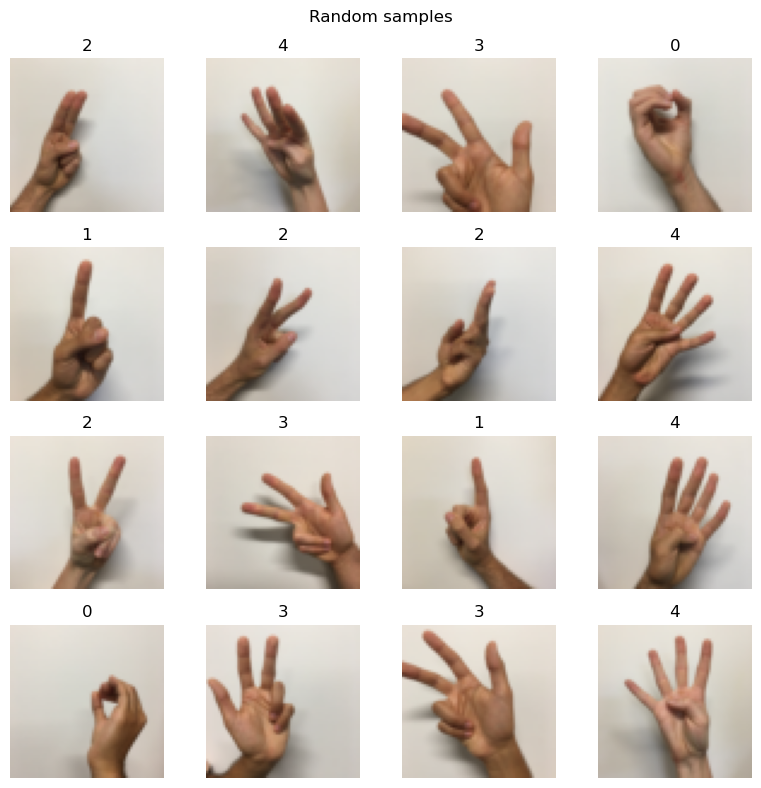

In [5]:
samples = [(train_X[i], train_y[i]) for i in np.random.randint(low=0, high=train_X.shape[0], size=16)]

fig, axs = plt.subplots(4, 4, figsize=(8, 8))
fig.suptitle('Random samples')

for i, ax in enumerate(axs.flat):
    ax.imshow(samples[i][0])
    ax.axis("off")
    ax.set_title(classes[samples[i][1]])

plt.tight_layout()
plt.show()

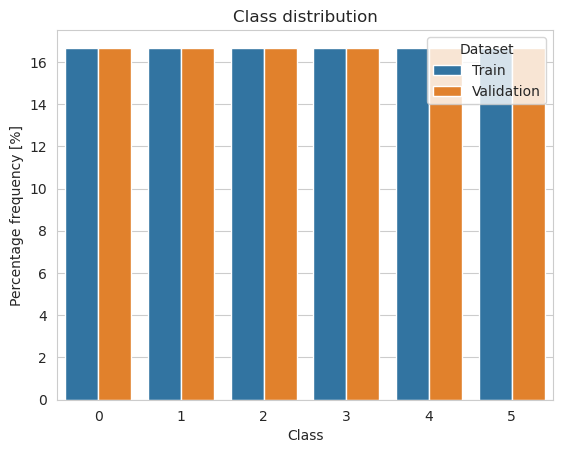

In [6]:
sns.set_style("whitegrid")

classes_frequency = pd.DataFrame(data={"Class": 2 * list(classes),
                                       "Frequency": list(100 * np.unique(train_y, return_counts=True)[1] / train_y.shape[0]) + list(100 * np.unique(validation_y, return_counts=True)[1] / validation_y.shape[0]),
                                       "Dataset": 6 * ["Train"] + 6 * ["Validation"]})

plt.figure()
sns.barplot(data=classes_frequency, x="Class", y="Frequency", hue="Dataset")
plt.xlabel("Class")
plt.ylabel("Percentage frequency [%]")
plt.title("Class distribution")
plt.show()

## Convolutional neural network

### Create the model

In [7]:
model1 = Sequential([Input(shape=(64, 64, 3)),
                     # Rescale
                     layers.Rescaling(scale=1 / 255),
                     # Data augmentation
                     layers.RandomFlip(mode="horizontal"),
                     layers.RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode="nearest"),
                     layers.RandomRotation(factor=0.2, fill_mode="nearest"),
                     layers.RandomZoom(height_factor=0.2, width_factor=0.2, fill_mode="nearest"),
                     # Convolutional layers
                     layers.Conv2D(16, 3, padding='same', activation='relu'),
                     layers.MaxPooling2D(),
                     layers.Conv2D(32, 3, padding='same', activation='relu'),
                     layers.MaxPooling2D(),
                     layers.Conv2D(64, 3, padding='same', activation='relu'),
                     layers.MaxPooling2D(),
                     # Deep layers
                     layers.Flatten(),
                     layers.Dense(128, activation="relu"),               
                     layers.Dense(6, activation="softmax")])

model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_translation              │ (None, 64, 64, 3)      │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 64, 64, 3)      │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 548,774 (2.09 MB)

 Trainable params: 548,774 (2.09 MB)

 Non-trainable params: 0 (0.00 B)

### Compile the model

In [8]:
model1.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

### Fit the model

In [9]:
history1 = model1.fit(train_ds, epochs=500, verbose=0, validation_data=validation_ds)

2024-06-24 11:57:02.927355: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


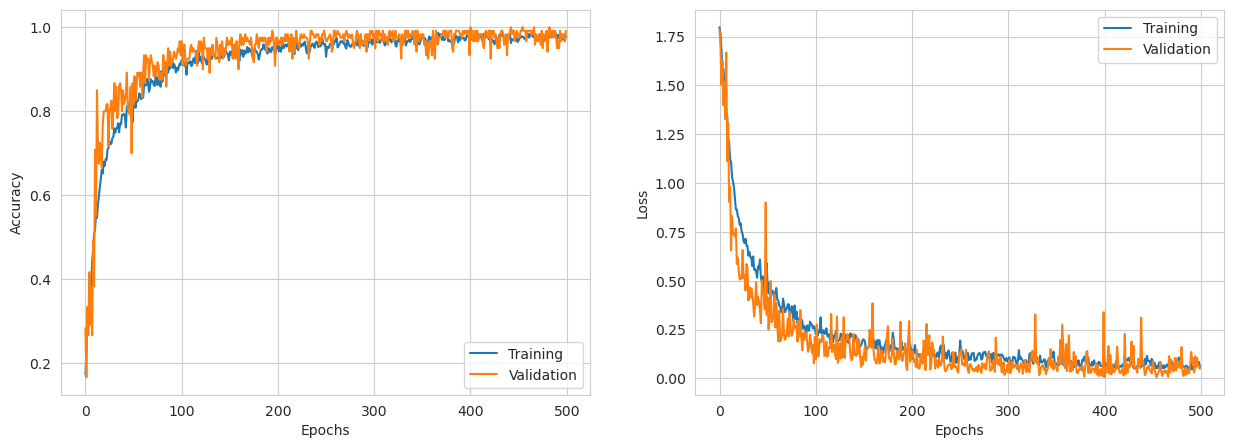

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(history1.history['accuracy'])
ax1.plot(history1.history['val_accuracy'])
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy")
ax1.legend(["Training", "Validation"])

ax2.plot(history1.history['loss'])
ax2.plot(history1.history['val_loss'])
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
ax2.legend(["Training", "Validation"])

plt.show()

### Evaluate the model

2024-06-24 11:59:03.341008: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


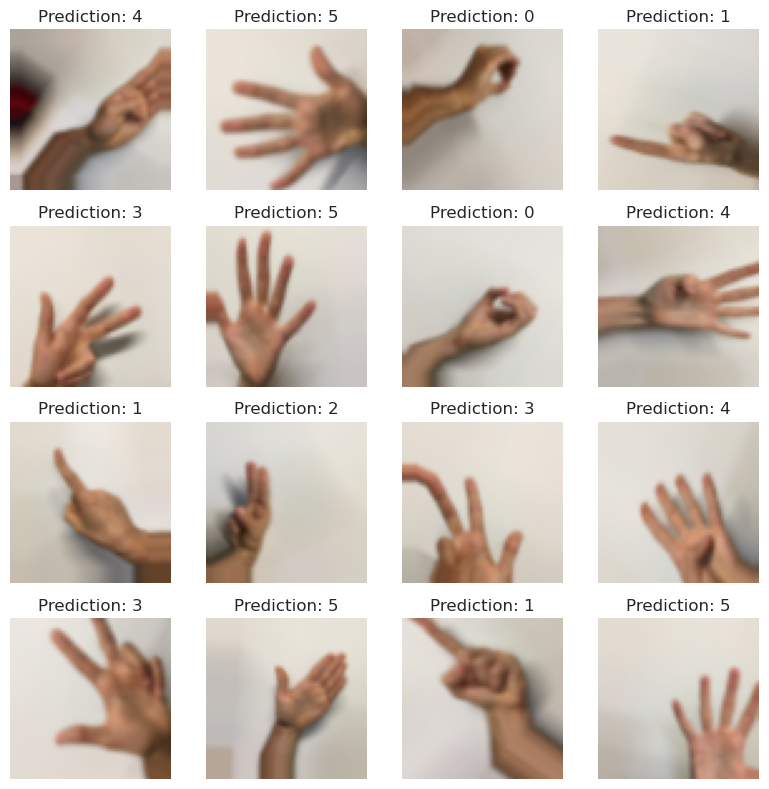

In [11]:
data_augmentation = Sequential([layers.RandomFlip(mode="horizontal"),
                                layers.RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode="nearest"),
                                layers.RandomRotation(factor=0.2, fill_mode="nearest"),
                                layers.RandomZoom(height_factor=0.2, width_factor=0.2, fill_mode="nearest")])

fig, axs = plt.subplots(4, 4, figsize=(8, 8))

for images, labels in validation_ds.take(np.random.randint(low=1, high=validation_ds.cardinality().numpy() + 1)).map(lambda x, y: (data_augmentation(x), y)):
    for i, ax in enumerate(axs.flat):
        prediction_proba = model1.predict(np.expand_dims(images[i], axis=0), verbose=0)
        ax.imshow(images[i] / 255)
        ax.axis("off")
        ax.set_title("Prediction: " + classes[np.argmax(prediction_proba.squeeze())])

plt.tight_layout()
plt.show()

## ResNet50V2

### Instantiate the ResNet50V2 architecture

In [12]:
ResNet50V2 = applications.ResNet50V2(include_top=False, input_shape=(64, 64, 3))

### Create the model

In [13]:
data_augmentation = Sequential([layers.RandomFlip(mode="horizontal"),
                                layers.RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode="nearest"),
                                layers.RandomRotation(factor=0.2, fill_mode="nearest"),
                                layers.RandomZoom(height_factor=0.2, width_factor=0.2, fill_mode="nearest")])

inputs = Input(shape=(64, 64, 3))
x = data_augmentation(inputs)
x = applications.resnet_v2.preprocess_input(x)
x = ResNet50V2(x)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(6, activation="softmax")(x)

model2 = Model(inputs, outputs)
model2.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 2, 2, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │        12,294 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,577,094 (89.94 MB)

 Trainable params: 23,531,654 (89.77 MB)

 Non-trainable params: 45,440 (177.50 KB)

### Compile the model

In [14]:
model2.compile(optimizer=optimizers.Adam(5e-5), loss='categorical_crossentropy', metrics=['accuracy'])

### Fit the model

In [15]:
history2 = model2.fit(train_ds, epochs=100, verbose=0, validation_data=validation_ds)

2024-06-24 11:59:29.980249: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.41GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-06-24 11:59:30.310301: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.30GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-06-24 11:59:30.456154: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.66GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-06-24 11:59:30.659302: W external/local_tsl/tsl/framework/bfc_

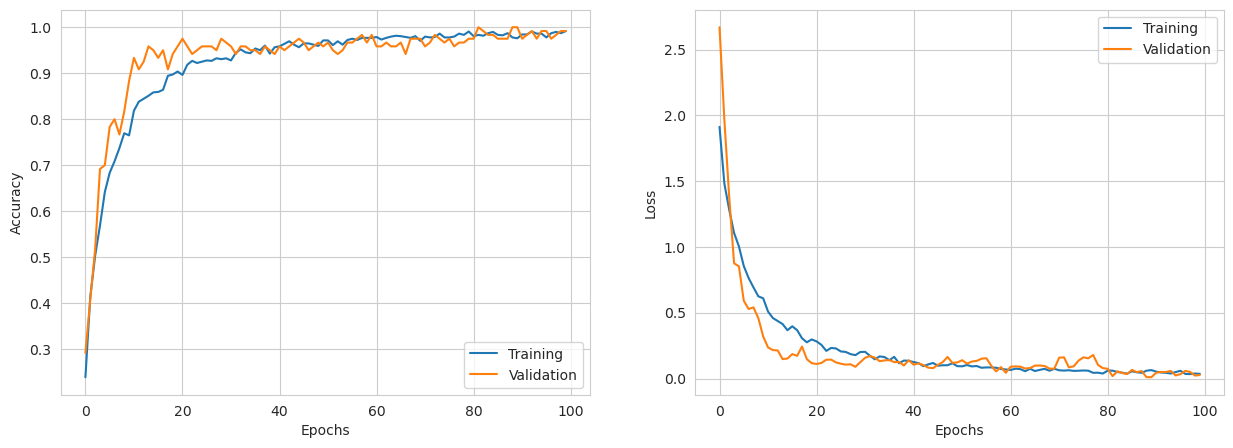

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(history2.history['accuracy'])
ax1.plot(history2.history['val_accuracy'])
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy")
ax1.legend(["Training", "Validation"])

ax2.plot(history2.history['loss'])
ax2.plot(history2.history['val_loss'])
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
ax2.legend(["Training", "Validation"])

plt.show()

### Evaluate the model

2024-06-24 12:06:54.107528: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


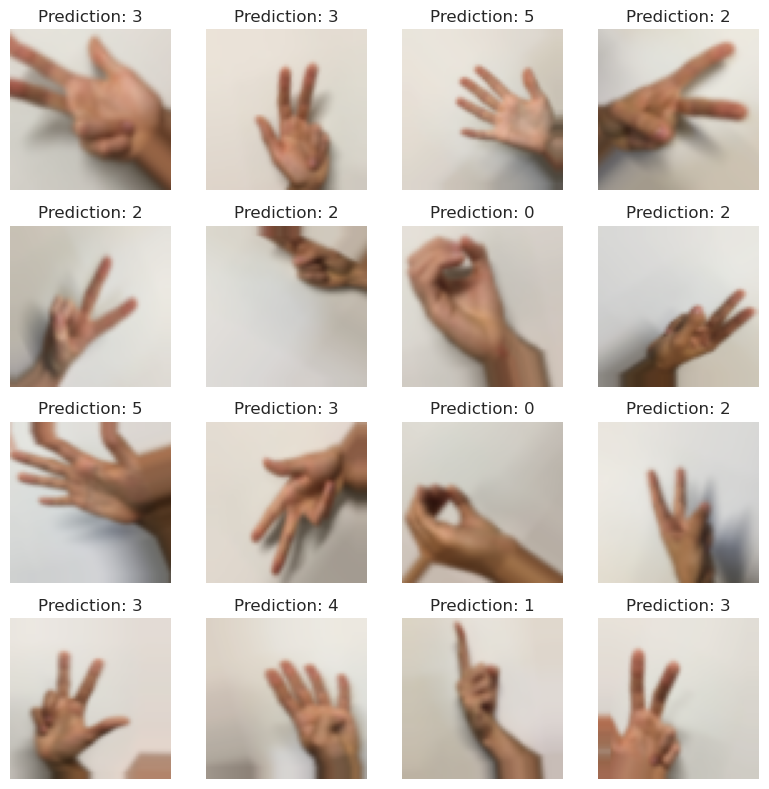

In [17]:
data_augmentation = Sequential([layers.RandomFlip(mode="horizontal"),
                                layers.RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode="nearest"),
                                layers.RandomRotation(factor=0.2, fill_mode="nearest"),
                                layers.RandomZoom(height_factor=0.2, width_factor=0.2, fill_mode="nearest")])

fig, axs = plt.subplots(4, 4, figsize=(8, 8))

for images, labels in validation_ds.take(np.random.randint(low=1, high=validation_ds.cardinality().numpy() + 1)).map(lambda x, y: (data_augmentation(x), y)):
    for i, ax in enumerate(axs.flat):
        prediction_proba = model2.predict(np.expand_dims(images[i], axis=0), verbose=0)
        ax.imshow(images[i] / 255)
        ax.axis("off")
        ax.set_title("Prediction: " + classes[np.argmax(prediction_proba.squeeze())])

plt.tight_layout()
plt.show()

## Model comparison

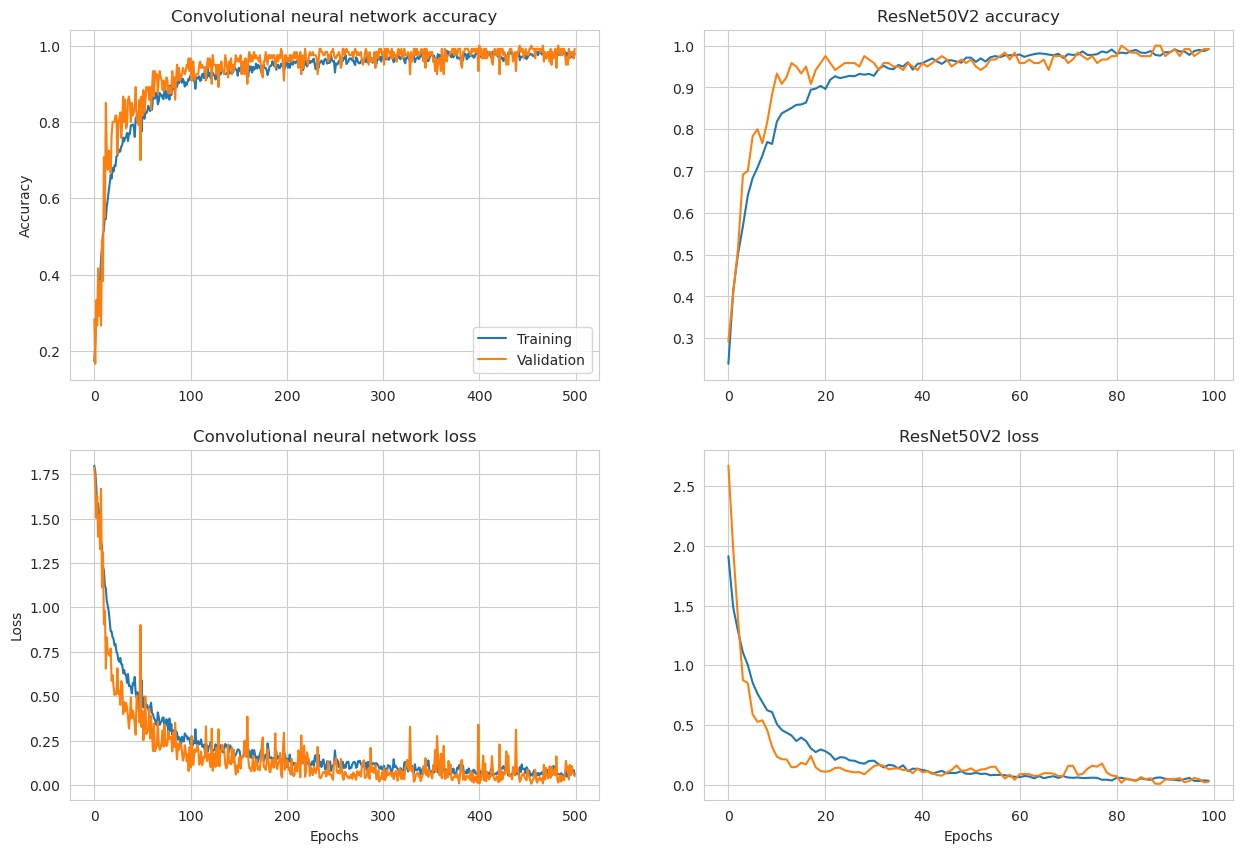

In [22]:
model1_accuracies = [history1.history['accuracy'], history1.history['val_accuracy']]
model2_accuracies = [history2.history['accuracy'], history2.history['val_accuracy']]
model1_losses = [history1.history['loss'], history1.history['val_loss']]
model2_losses = [history2.history['loss'], history2.history['val_loss']]

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

for model1_accuracy in model1_accuracies:  
    axs[0, 0].plot(model1_accuracy)
    axs[0, 0].set_ylabel("Accuracy")
    axs[0, 0].set_title("Convolutional neural network accuracy")
    axs[0, 0].legend(["Training", "Validation"])

for model2_accuracy in model2_accuracies:  
    axs[0, 1].plot(model2_accuracy)
    axs[0, 1].set_title("ResNet50V2 accuracy")

for model1_loss in model1_losses:  
    axs[1, 0].plot(model1_loss)
    axs[1, 0].set_xlabel("Epochs")
    axs[1, 0].set_ylabel("Loss")
    axs[1, 0].set_title("Convolutional neural network loss")

for model2_loss in model2_losses:  
    axs[1, 1].plot(model2_loss)
    axs[1, 1].set_xlabel("Epochs")
    axs[1, 1].set_title("ResNet50V2 loss")

plt.show()

## Conclusions

On a simple dataset such as finger signs, both the basic **convolutional neural network** and **ResNet50V2** have very good performance, giving practically the same results. However, a complex architecture like ResNet50V2 requires much more time to train than the basic convolutional neural.

In [19]:
!rm -rf ./data